In [1]:
using Revise

In [31]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

## Define CaOH Hamiltonian and molecular states

In [89]:

function get_CaF_package()
    λ = 606e-9
    Γ = 2π* 8.3e6
    m = @with_unit 59 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    
    QN_bounds = (
        S = 1/2, 
        I = 1/2, 
        Λ = 0, 
        N = 0:3
    )
    X_state_basis = enumerate_states(HundsCaseB_LinearMolecule, QN_bounds)

    X_state_operator = :(
        BX * Rotation + 
        DX * RotationDistortion + 
        γX * SpinRotation + 
        bFX * Hyperfine_IS + 
        cX * (Hyperfine_Dipolar/3)
    )

    X_state_parameters = QuantumStates.@params begin
        BX = 10303.988
        DX = 0.014060
        γX = 39.65891
        bFX = 122
        cX = 40.1182
    end

    X_state_ham = Hamiltonian(basis=X_state_basis, operator=X_state_operator, parameters=X_state_parameters)

    # Add Zeeman terms
   
    X_state_ham = add_to_H(X_state_ham, :B_x, (gS * _μB * 1e-6) * Zeeman_x)
    X_state_ham = add_to_H(X_state_ham, :B_y, (gS * _μB * 1e-6) * Zeeman_y)
    X_state_ham = add_to_H(X_state_ham, :B_z, (gS * _μB * 1e-6) * Zeeman_z)
    X_state_ham.parameters.B_x = 0.
    X_state_ham.parameters.B_y = 0.
    X_state_ham.parameters.B_z = -1e-5

    evaluate!(X_state_ham)
    QuantumStates.solve!(X_state_ham)
    ;

    QN_bounds = (
        S = 1/2,
        I = 1/2,
        Λ = (-1,1),
        J = 1/2:5/2
    )
    A_state_basis = enumerate_states(HundsCaseA_LinearMolecule, QN_bounds)

    A_state_operator = :(
        T_A * DiagonalOperator +
        Be_A * Rotation + 
        Aso_A * SpinOrbit +
        q_A * ΛDoubling_q +
        p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q)
    )

    # Spectroscopic constants for CaOH, A state
    A_state_parameters = QuantumStates.@params begin
        T_A = 16526.750 * 299792458 * 1e-4
        Be_A = 0.348781 * 299792458 * 1e-4
        Aso_A = 71.429 * 299792458 * 1e-4
        p_A = -0.044517 * 299792458 * 1e-4
        q_A = -2.916e-4 * 299792458 * 1e-4
    end

    A_state_ham = Hamiltonian(basis=A_state_basis, operator=A_state_operator, parameters=A_state_parameters)
    evaluate!(A_state_ham)
    QuantumStates.solve!(A_state_ham)
    ;

    A_state_J12_pos_parity_states = A_state_ham.states[5:8]

    QN_bounds = (
        S = 1/2, 
        I = 1/2, 
        Λ = (-1,1), 
        N = 0:3
    )
    A_state_caseB_basis = enumerate_states(HundsCaseB_LinearMolecule, QN_bounds)

    ground_states = X_state_ham.states[5:16]
    excited_states = convert_basis(A_state_J12_pos_parity_states, A_state_caseB_basis)

    states = [ground_states; excited_states]
    n_excited = length(excited_states)

    for state ∈ states
        state.E *= 1e6
    end
    ;

    d = zeros(ComplexF64, 16, 16, 3)
    d_ge = zeros(ComplexF64, 12, 4, 3)

    basis_tdms = get_tdms_two_bases(X_state_ham.basis, A_state_caseB_basis, TDM)
    tdms_between_states!(d_ge, basis_tdms, ground_states, excited_states)
    d[1:12, 13:16, :] .= d_ge
    
    #     Zeeman_x(state, state′) = (Zeeman(state, state′,-1) - Zeeman(state, state′,1))/sqrt(2)
    #     Zeeman_y(state, state′) = im*(Zeeman(state, state′,-1) + Zeeman(state, state′,1))/sqrt(2)
    #     Zeeman_z(state, state′) = Zeeman(state, state′, 0)

    Zeeman_x_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_x, ground_states, excited_states) .* (2π*gS*_μB/Γ))
    Zeeman_y_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_y, ground_states, excited_states) .* (2π*gS*_μB/Γ))
    Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, ground_states, excited_states) .* (2π*gS*_μB/Γ))
                

    package = MutableNamedTuple(states=states, n_excited=n_excited, d=d, Zeeman_x_mat=Zeeman_x_mat, Zeeman_y_mat=Zeeman_y_mat, Zeeman_z_mat=Zeeman_z_mat, Γ = Γ , k = k, m = m)
    return package
end;

λ = 606e-9
Γ = 2π* 8.3e6
m = @with_unit 59 "u"
k = 2π / λ
package = get_CaF_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = package
k = package.k
Γ = package.Γ
m = package.m;

In [14]:
μ_B = 9.2740100783e-24
package = get_CaOH_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = package #get_CaOH_package_12_A_states(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m;
λ = 626e-9
Γ = 2π* 6.4e6
m = @with_unit 57 "u"
k = 2π / λ;

In [3]:

energy.(package.states) .- energy(package.states[1])

16-element Vector{Float64}:
    0.0
 7480.522541046143
 7485.5417556762695
 7490.5561599731445
    5.124028577622223e7
    5.1240297798942566e7
    5.1240309821899414e7
    5.275483346474075e7
    5.275484047121048e7
    5.275484747696686e7
    5.275485448302078e7
    5.275486148970032e7
    4.7860092421321225e14
    4.7860092421321244e14
    4.786009242132125e14
    4.786009242132126e14

In [99]:
package.states[10].E - package.states[1].E

1.472908195291214e8

In [18]:
(s1 + s2 + s3)*3.4*2.2

30.022988464855136

## Define experimental parameters

In [22]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ3 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ3, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 0.1 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = 70 ; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
Δ3, Δ2 = Δ2, Δ3



# ## Laser intensities CaOH
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2 # mW

r1 = 3.7
r3 = 2.8 
r2 = 3.5 

# # r1 = 1
# # r3 = 1
# # r2 = 0

p1 = r1/(r1+r2+r3) * power_total
p3 = r3/(r1+r2+r3) * power_total
p2 = r2/(r1+r2+r3) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 2 * p2 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 0.0
s5 = 0.0


# CaF:
# Δ1 = 20e6
# Δ2 = (0.5+20)*1e6
# Δ3 = (-1.5 + 20) * 1e6
Δ4 = 0.0
Δ5 = 0.0

# s1 = s2 = s3 = 2/3 * 2
# s4 = s5 = 0.0


blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 20,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁺, pol5_x = σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_grad_start = 0.0,
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 1,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2,

                                diffusion_constant =0.00)
;

In [30]:
s1, s2, s3

(1.4850943491973796, 1.4048189789704941, 1.1238551831763952)

In [23]:
Δ1, Δ2, Δ3

(7.599999999999994e6, 5.089999999999996e6, 6.839999999999996e6)

## Find the diffusion constant

In [46]:
# aom1_freq = 51
# Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6*2π)
# blue_MOT_params.Δ3 = Δ3

# res, diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=2e-4, n_particles=20, 
#                                         ramp_time=1e-6, temp = 1e-4, diameter=200e-6)
# blue_MOT_params.diffusion_constant = diffusion_constant
# @printf("Diffusion const = %.2f \n", diffusion_constant)

## Run a constant-diffusion simulation
Define an experimental sequence. In this example, it's just the blue MOT. But we could also simulate an entire experimental sequence, such as 
red MOT -> lambda cooling -> blue MOT -> single frequency cooling -> ODT loading

In [34]:
blue_MOT_params.n_values = 40
sequence = [blue_MOT_params]
durations = [10e-3]
generate_sequence!(sequence, durations);
@time results2 = simulate_particles_constant_diffusion(package, package_A, sequence);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


123.750905 seconds (9.16 G allocations: 209.340 GiB, 22.30% gc time, 78.57% compilation time)


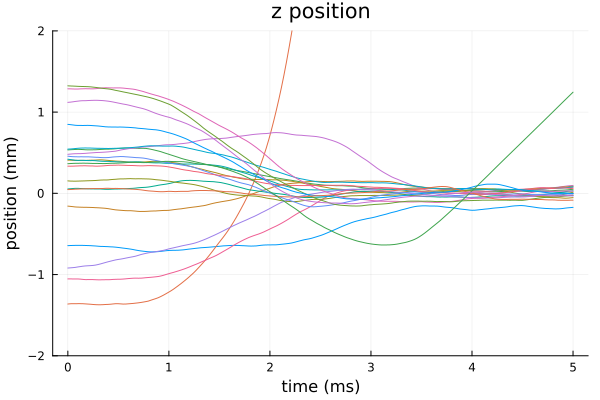

In [32]:
plot_all_trajectories(results, "z")
plot!(ylim=[-2,2])

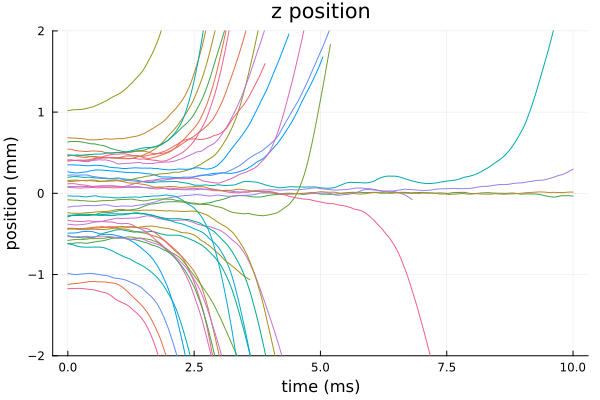

In [35]:
plot_all_trajectories(results2, "z")
plot!(ylim=[-2,2])

In [37]:
plot_all_trajectories(results2, "z")
plot!(ylim=[-1,1],xlim=[0,10],title="",framestyle=:box,size=[430,300],grid=:off,ylabel="x (mm)",dpi=300)
savefig("C:\\Users\\halla\\OneDrive\\Desktop\\CaOH_12_anticb_trajectories.png")

"C:\\Users\\halla\\OneDrive\\Desktop\\CaOH_12_anticb_trajectories.png"

In [87]:
plot_all_trajectories(results, "z")
plot!(ylim=[-1,1],xlim=[0,10],title="",framestyle=:box,size=[430,300],grid=:off,ylabel="x (mm)",dpi=300)
savefig("C:\\Users\\halla\\OneDrive\\Desktop\\CaOH_12_trajectories.png")


"C:\\Users\\halla\\OneDrive\\Desktop\\CaOH_12_trajectories.png"

In [88]:
plot_all_trajectories(results11, "z")
plot!(ylim=[-1,1],xlim=[0,10],title="",framestyle=:box,size=[430,300],grid=:off,ylabel="x (mm)",dpi=300)
savefig("C:\\Users\\halla\\OneDrive\\Desktop\\CaOH_11_trajectories.png")


"C:\\Users\\halla\\OneDrive\\Desktop\\CaOH_11_trajectories.png"

In [74]:
results12 = results;

### Or load an existing simulation result
The example here is a 1000 particle blue MOT simulation for 7.1 ms

In [27]:
results = load_results("",1);

## Plot simulation results

### Plot the molecules' trajectories

Note that molecules that are too far away from the centre are discarded, which is why some trajectories end prematurely.

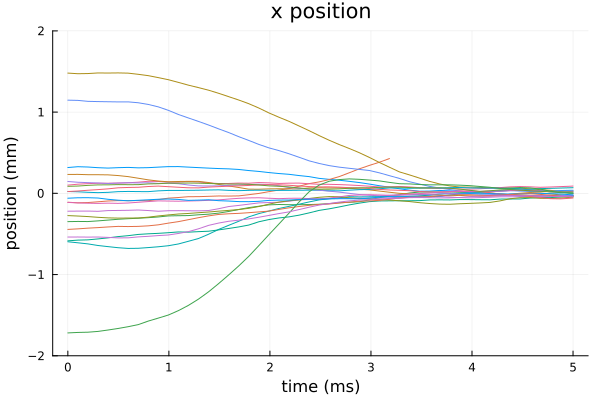

In [17]:
plot_all_trajectories(results, "x")
plot!(ylim=[-2,2])

### Plot the cloud size over time 
The size here is obtained from the standard deviation of the position distribution.
There is also an option to find the final cloud size by fitting to a Gaussian.

Final size = 0.094 mm

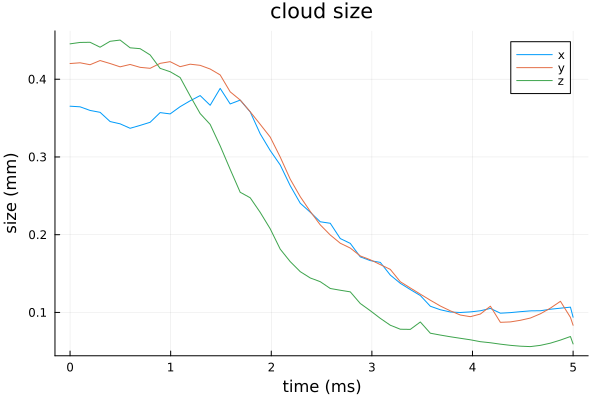

In [14]:
~, σ = plot_size(results,"all")
@printf("Final size = %.3f mm", σ[end])
plot!()

In [15]:
bootstrap_size_fit(results,5,iter=100)

(0.06337209352816585, 0.004092925019390378)

In [17]:
bootstrap_temperature_fit(results,5,iter=100)

(180.44273870496866, 18.03513434600427)

### Plot temperature over time 
Temperatures here are obtained from the standard deviation of the velocity distribution. One could also fit the velocity distribution to a Gaussian.

Temperature = 220.1 uK

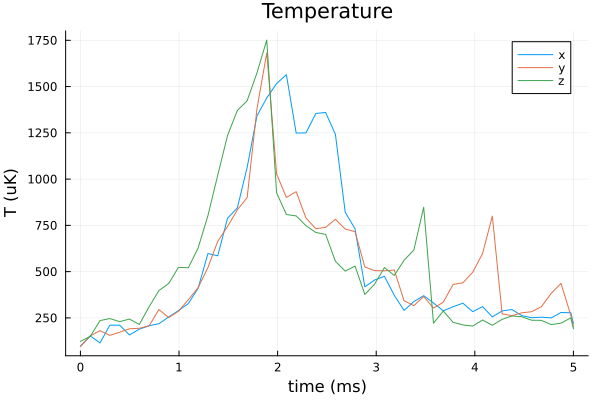

In [16]:
~, T = plot_temperature(results, "all")
@printf("Temperature = %.1f uK", T[end])
plot!()

### Plot the scattering rate of the molecules 
Scattering rate = excited state population * Γ

Average scattering rate = 1.19 MHz

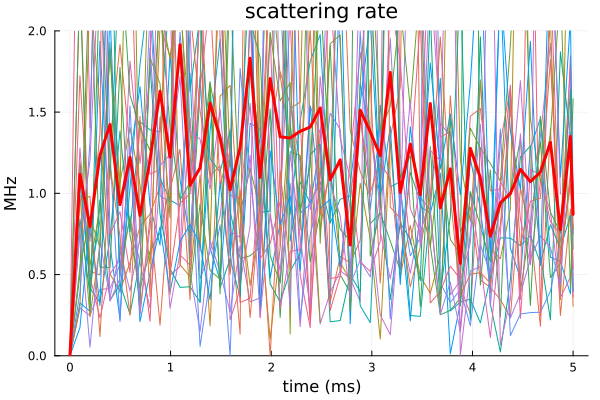

In [12]:
sr = plot_scattering_rate(results)
@printf("Average scattering rate = %.2f MHz", sr)
plot!(ylim=[0,2])

### Simulate camera images
We can also generate "camera images" by taking 2D snapshots (integrated over y direction) of the molecules.

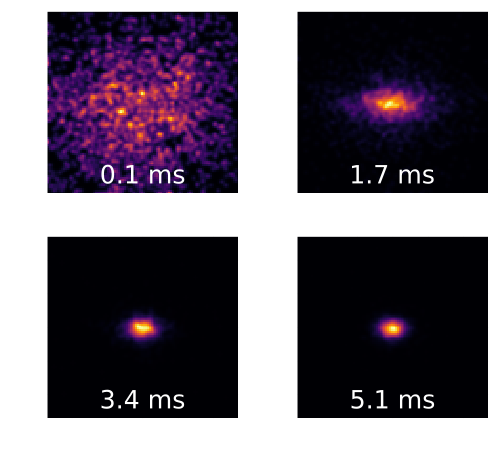

In [32]:
ROI = 0.8  # mm

img_duration = 2.0   # the image will be averaged over this duration
n_pixels = 100

ts = [0.1,1.7,3.4,5.1]
filter = 1.   # Gaussian filtering the image

plots = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.0, photon_budget=12000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    p = heatmap(x,z,imgg',legend=:none, xaxis=false, yaxis=false)
    annotate!(0,-ROI*0.8,text(@sprintf("%.1f ms", t),:white,17))
    push!(plots, p)
end

plot(plots[1],plots[2],plots[3],plots[4], size=(500,450))
    
plot!()

In [3]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ2, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 100e-3 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = 75; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ4 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6*2π)
Δ2 = 0.0


## Laser intensities
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2*1.3 # mW

p1 = 3.7/(3.7 + 2.8 + 3.5) * power_total
p3 = 2.8/(3.7 + 2.8 + 3.5) * power_total
p4 = 3.5/(3.7 + 2.8 + 3.5) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 0.0
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 2 * p4 / (π * 0.5^2) / 3.4



blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 1e-4, n_values = 1,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2,

                                diffusion_constant =0.0)
;

In [4]:
prob = make_problem_with_param_diffusion(package, package_A, blue_MOT_params);

In [25]:

using
    DifferentialEquations,
    LinearAlgebra
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using Parameters

import ProgressMeter: Progress, next!

import OpticalBlochEquations.simulate_particles_constant_diffusion

function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx 
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    τ_bfield = p.sim_params.B_ramp_time 
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    gradient_x = +(scalar * p.sim_params.B_gradient + p.sim_params.B_grad_start) * 1e2 / k/2 
    gradient_y = +(scalar * p.sim_params.B_gradient+ p.sim_params.B_grad_start) * 1e2 / k/2 
    gradient_z = -(scalar * p.sim_params.B_gradient+ p.sim_params.B_grad_start) * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    # Update the Hamiltonian for the molecule-ODT interaction
    H_ODT = p.extra_data.H_ODT_static
    
    ODT_size = p.sim_params.ODT_size .* p.k
    update_ODT_center!(p, t)
    ODT_x = p.extra_data.ODT_position[1] * p.k
    ODT_z = p.extra_data.ODT_position[2] * p.k
    
    scalar_ODT = exp(-2(r[1]-ODT_x)^2/ODT_size[1]^2) * exp(-2r[2]^2/ODT_size[2]^2) * exp(-2(r[3]-ODT_z)^2/ODT_size[3]^2)
    
    @turbo for i in eachindex(H)
        H.re[i] += H_ODT.re[i] * scalar_ODT
        H.im[i] += H_ODT.im[i] * scalar_ODT
    end
    
    # return SVector{3,ComplexF64}(0,0,0)
    return SVector{3,ComplexF64}((-4(r[1]-ODT_x) / ODT_size[1]^2) * scalar_ODT, (-4r[2] / ODT_size[2]^2) * scalar_ODT, (-4(r[3]-ODT_z) / ODT_size[3]^2) * scalar_ODT)
    
end
;

function make_problem_with_param_constant_diffusion(molecule_package, package_A, param; randomize_initial_vector = true, ψ0=nothing)       
    Γ = molecule_package.Γ
    k = molecule_package.k
    m = molecule_package.m
    ħ = 1.0545718176461565e-34
    λ = 2π/k 

    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x

    s1, s2, s3, s4 = param.s1, param.s2, param.s3, param.s4
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4 = param.Δ1, param.Δ2, param.Δ3, param.Δ4
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick

    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1],m)
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2],m)
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3],m)

  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
   photon_budget = param.photon_budget

    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        B_grad_start = param.B_grad_start,
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,
        
        s_total = s1 + s2 + s3 + s4,
        diffusion_constant = param.diffusion_constant
        )

    t_span = (t_start, t_end) ./ (1/Γ);
    #TODO
    ω1 = 2π * (states[end].E - states[1].E) + Δ1 * 2π
    ω2 = 2π * (states[end].E - states[10].E)  + Δ2 * 2π
    ω3 = 2π * (states[end].E - states[10].E)  + Δ3 * 2π
    ω4 = 2π * (states[end].E - states[10].E)  + Δ4 * 2π

    ϵ_(ϵ, f) = t -> ϵ
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers,k)
    
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers,k)
    
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance)  + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    
    sx_rand = 1.0#1/2-rand()
    sy_rand = 1.0#1/2-rand()
    sz_rand = 1.0#1/2-rand()

    # TODO: put retros back
    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ = kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ_func1 = ϵ_(ϵ1, 1); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ_func2 = ϵ_(ϵ2, 2); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ_func3 = ϵ_(ϵ3, 3); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ_func4 = ϵ_(ϵ4, 4); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ_func5 = ϵ_(ϵ5, 5); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z , s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ_func6 = ϵ_(ϵ6, 6); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ_func7 = ϵ_(ϵ7, 1); laser7 = Field(k̂, ϵ_func7, ω2, s_gaussian_ramp(s2x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ_func8 = ϵ_(ϵ8, 2); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ_func9 = ϵ_(ϵ9, 3); laser9 = Field(k̂, ϵ_func9, ω2, s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ_func10 = ϵ_(ϵ10, 4); laser10 = Field(k̂, ϵ_func10, ω2, s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ_func11 = ϵ_(ϵ11, 5); laser11 = Field(k̂, ϵ_func11, ω2, s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ_func12 = ϵ_(ϵ12, 6); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss) , s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ_func13 = ϵ_(ϵ13, 1); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ_func14 = ϵ_(ϵ14, 2); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ_func15 = ϵ_(ϵ15, 3); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ_func16 = ϵ_(ϵ16, 4); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ_func17 = ϵ_(ϵ17, 5); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ_func18 = ϵ_(ϵ18, 6); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ_func19 = ϵ_(ϵ19, 1); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ_func20 = ϵ_(ϵ20, 2); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ_func21 = ϵ_(ϵ21, 3); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ_func22 = ϵ_(ϵ22, 4); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ_func23 = ϵ_(ϵ23, 5); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ_func24 = ϵ_(ϵ24, 6); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    lasers = [lasers_1;lasers_2; lasers_3; lasers_4]
        
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)
    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end
               
    return prob
end

function simulate_particles_constant_diffusion(package, package_A, sequence_of_params)
    
    n_values = sequence_of_params[1].n_values
    n_threads=Threads.nthreads()
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    prog_bar = Progress(n_values)

    n_states = length(package.states)
    n_excited = package.n_excited

    x_trajectories = Array{Vector{Float64}}(fill([],n_values))
    y_trajectories = Array{Vector{Float64}}(fill([],n_values)) 
    z_trajectories = Array{Vector{Float64}}(fill([],n_values))
    x_velocities = Array{Vector{Float64}}(fill([],n_values))
    y_velocities = Array{Vector{Float64}}(fill([],n_values))
    z_velocities = Array{Vector{Float64}}(fill([],n_values))
    A_populations = Array{Vector{Float64}}(fill([],n_values))
    times = Array{Vector{Float64}}(fill([],n_values))
    photons_scattered = zeros(n_values)

                            
    results = MutableNamedTuple(x_trajectories = x_trajectories, y_trajectories= y_trajectories, z_trajectories=z_trajectories,
                                x_velocities = x_velocities, y_velocities=y_velocities, z_velocities=z_velocities,
                                times=times, A_populations=A_populations,
                                n_values=n_values, photons_scattered=photons_scattered, n_states = n_states, n_excited=n_excited,
                                Γ = package.Γ, k=package.k)

    cb = ContinuousCallback(condition, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))

    Threads.@threads for i ∈ 1:n_threads
    
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)

        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1) 
            ψ0 = nothing
            for i_param in 1:length(sequence_of_params)
                randomize = false
                if i_param == 1
                     randomize = true
                end
                params = sequence_of_params[i_param]      
                prob_copy = make_problem_with_param_constant_diffusion(package, package_A, params, randomize_initial_vector = randomize, ψ0=ψ0)
                ψ0 = continue_particle_constant_diffusion!(j, results, prob_copy)    
                if abs(params.t_end - results.times[j][end]*1e-3) > 1e-3
                          break # this particle has already died
                end
            end

            next!(prog_bar)
        end
    end
    
    return results
end
                                
function simulate_particles_constant_diffusion_given_init(package, package_A, sequence_of_params, velocities)
    
    n_values = sequence_of_params[1].n_values
    n_threads=Threads.nthreads()
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    prog_bar = Progress(n_values)

    n_states = length(package.states)
    n_excited = package.n_excited

    x_trajectories = Array{Vector{Float64}}(fill([],n_values))
    y_trajectories = Array{Vector{Float64}}(fill([],n_values)) 
    z_trajectories = Array{Vector{Float64}}(fill([],n_values))
    x_velocities = Array{Vector{Float64}}(fill([],n_values))
    y_velocities = Array{Vector{Float64}}(fill([],n_values))
    z_velocities = Array{Vector{Float64}}(fill([],n_values))
    A_populations = Array{Vector{Float64}}(fill([],n_values))
    times = Array{Vector{Float64}}(fill([],n_values))
    photons_scattered = zeros(n_values)

                            
    results = MutableNamedTuple(x_trajectories = x_trajectories, y_trajectories= y_trajectories, z_trajectories=z_trajectories,
                                x_velocities = x_velocities, y_velocities=y_velocities, z_velocities=z_velocities,
                                times=times, A_populations=A_populations,
                                n_values=n_values, photons_scattered=photons_scattered, n_states = n_states, n_excited=n_excited,
                                Γ = package.Γ, k=package.k)

    cb = ContinuousCallback(condition, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))

    Threads.@threads for i ∈ 1:n_threads
    
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)

        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1) 
            ψ0 = nothing
            for i_param in 1:length(sequence_of_params)
                randomize = false
                if i_param == 1
                     randomize = true
                end

                params = deepcopy(sequence_of_params[i_param])    
                params.kick = [velocities[j], velocities[j], 0]
                prob_copy = make_problem_with_param_constant_diffusion(package, package_A, params, randomize_initial_vector = randomize, ψ0=ψ0)
                ψ0 = continue_particle_constant_diffusion!(j, results, prob_copy)    
                if abs(params.t_end - results.times[j][end]*1e-3) > 1e-3
                          break # this particle has already died
                end
            end

            next!(prog_bar)
        end
    end
    
    return results
end                               
                                


import OpticalBlochEquations.SE_collapse_pol_constant_diffusion!
function SE_collapse_pol_constant_diffusion!(integrator)

    p = integrator.p
    n_states = p.n_states
    n_excited = p.n_excited
    n_ground = p.n_ground
    d = p.d
    ψ = integrator.u
    
    
 
    
    # A photon is observed.
    # Measure the polarization of the photon along z.
    p⁺ = 0.0
    p⁰ = 0.0
    p⁻ = 0.0
    
    for i ∈ 1:n_excited
        ψ_pop = norm(ψ[n_ground + i])^2
        for j ∈ 1:n_ground
            p⁺ += ψ_pop * norm(d[j,n_ground+i,1])^2
            p⁰ += ψ_pop * norm(d[j,n_ground+i,2])^2
            p⁻ += ψ_pop * norm(d[j,n_ground+i,3])^2
        end
        # note the polarization p in d[:,:,p] is defined to be m_e - m_g, 
        # whereas the polarization of the emitted photon is m_g - m_e
    end
    
    p_norm = p⁺ + p⁰ + p⁻
    rn = rand() * p_norm
    for i ∈ 1:n_ground
        ψ[i] = 0.0
    end

    
    pol = 0
    if 0 < rn <= p⁺ # photon is measured to have polarization σ⁺
        pol = 1
    elseif p⁺ < rn <= p⁺ + p⁰ # photon is measured to have polarization σ⁰
        pol = 2
    else # photon is measured to have polarization σ⁻
        pol = 3
    end
    
    for i in 1:n_ground
        for j in (n_ground+1):n_states
            ψ[i] += ψ[j] * d[i,j,pol]
        end
    end
    
    # zero excited state amplitudes
    for i ∈ (n_ground + 1):n_states
        ψ[i] = 0.0
    end
    
    ψ_norm = 0.0
    for i ∈ 1:n_states
        ψ_norm += norm(ψ[i])^2
    end
    ψ_norm = sqrt(ψ_norm)
    for i ∈ 1:n_states
        ψ[i] /= ψ_norm
    end
    
    p.n_scatters += 1
    
    # zero excited state populations
    for i ∈ (n_states+1):(n_states+n_excited)
        integrator.u[i] = 0.0
    end

    
    dp = sample_direction(1)
    dv = dp ./ p.mass
    integrator.u[n_states + n_excited + 4] += dv[1]
    integrator.u[n_states + n_excited + 5] += dv[2]
    integrator.u[n_states + n_excited + 6] += dv[3]
    
    time_before_decay = integrator.t - p.last_decay_time
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 4] += p.diffusion_constant*sqrt(time_before_decay)/p.mass * diffusion_direction
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 5] += p.diffusion_constant*sqrt(time_before_decay)/p.mass * diffusion_direction
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 6] += p.diffusion_constant*sqrt(time_before_decay)/p.mass * diffusion_direction
    
    p.last_decay_time = integrator.t
    
    p.time_to_decay = rand(p.decay_dist)
    return nothing
end
                                                                                        
                                                                                        
import OpticalBlochEquations.make_problem_with_param_diffusion
function make_problem_with_param_diffusion(molecule_package, package_A, param; randomize_initial_vector = true, ψ0=nothing)       
    Γ = molecule_package.Γ
    k = molecule_package.k
    m = molecule_package.m
    ħ = 1.0545718176461565e-34
    λ = 2π/k         
                
    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x

    s1, s2, s3, s4 = param.s1, param.s2, param.s3, param.s4
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4 = param.Δ1, param.Δ2, param.Δ3, param.Δ4
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick
    
    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1], m)
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2], m)
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3], m)
  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
    
    photon_budget = param.photon_budget

    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,

        dt = param.dt
        )

    t_span = (t_start, t_end) ./ (1/Γ)
    
    ω1 = 2π * (states[end].E - states[1].E) + Δ1 * 2π
    ω2 = 2π * (states[end].E - states[1].E)  + Δ2 * 2π
    ω3 = 2π * (states[end].E - states[6].E)  + Δ3 * 2π
    ω4 = 2π * (states[end].E - states[6].E)  + Δ4 * 2π

    ϵ_(ϵ, f) = t -> ϵ
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers,k)
    
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers,k)
    
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance)  + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    
    sx_rand = 1/2-rand()
    sy_rand = 1/2-rand()
    sz_rand = 1/2-rand()
    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ = kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ_func1 = ϵ_(ϵ1, 1); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ_func2 = ϵ_(ϵ2, 2); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ_func3 = ϵ_(ϵ3, 3); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ_func4 = ϵ_(ϵ4, 4); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ_func5 = ϵ_(ϵ5, 5); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ_func6 = ϵ_(ϵ6, 6); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ_func7 = ϵ_(ϵ7, 1); laser7 = Field(k̂, ϵ_func7, ω2, s_gaussian_ramp(s2x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ_func8 = ϵ_(ϵ8, 2); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ_func9 = ϵ_(ϵ9, 3); laser9 = Field(k̂, ϵ_func9, ω2, s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ_func10 = ϵ_(ϵ10, 4); laser10 = Field(k̂, ϵ_func10, ω2, s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ_func11 = ϵ_(ϵ11, 5); laser11 = Field(k̂, ϵ_func11, ω2, s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ_func12 = ϵ_(ϵ12, 6); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ_func13 = ϵ_(ϵ13, 1); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ_func14 = ϵ_(ϵ14, 2); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ_func15 = ϵ_(ϵ15, 3); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ_func16 = ϵ_(ϵ16, 4); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ_func17 = ϵ_(ϵ17, 5); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ_func18 = ϵ_(ϵ18, 6); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ_func19 = ϵ_(ϵ19, 1); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ_func20 = ϵ_(ϵ20, 2); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ_func21 = ϵ_(ϵ21, 3); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ_func22 = ϵ_(ϵ22, 4); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ_func23 = ϵ_(ϵ23, 5); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ_func24 = ϵ_(ϵ24, 6); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    lasers = [lasers_1;lasers_2; lasers_3; lasers_4]
                            
    p = schrodinger_stochastic_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; 
        sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_diffusion!, p.ψ, t_span, p)
    
    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end

     reset_operator_diagonal!(prob.p.P_x, prob.p.ψ[n_states + n_excited + 4] * prob.p.mass)
     reset_operator_diagonal!(prob.p.P_y, prob.p.ψ[n_states + n_excited + 5] * prob.p.mass)
     reset_operator_diagonal!(prob.p.P_z, prob.p.ψ[n_states + n_excited + 6] * prob.p.mass)
     
     reset_operator_diagonal!(prob.p.Px_sq, (prob.p.ψ[n_states + n_excited + 4] * prob.p.mass)^2)
     reset_operator_diagonal!(prob.p.Py_sq, (prob.p.ψ[n_states + n_excited + 5] * prob.p.mass)^2)
     reset_operator_diagonal!(prob.p.Pz_sq, (prob.p.ψ[n_states + n_excited + 6] * prob.p.mass)^2)
     
     reset_operator_diagonal!(prob.p.U_t, 1)
     reset_operator_diagonal!(prob.p.U_t_dagger, 1)
     
     for i ∈ eachindex(prob.p.ψ_prev)
         prob.p.ψ_prev[i] = prob.p.ψ[i]
     end
    
    return prob
end    

import OpticalBlochEquations.condition
function condition(u,t,integrator)
    p = integrator.p
    integrated_excited_pop = 0.0
    for i ∈ 1:p.n_excited
        integrated_excited_pop += real(u[p.n_states+i])
    end
    
    _condition = integrated_excited_pop - p.time_to_decay
    
    r = 0.0
    for i ∈ 1:3
        r += norm(u[p.n_states + p.n_excited + i])^2
    end
    r = sqrt(r)
    if r >= 5e-3*k # terminate if the particle is more than 3 mm from the centre
       terminate!(integrator) 
    elseif integrator.p.n_scatters > integrator.p.sim_params.photon_budget # also terminate if too many photons have been scattered
        terminate!(integrator)
    end
    return _condition
end


function gaussian_intensity_along_axes(r, axes, centers)
    """1/e^2 width = 5mm Gaussian beam """
    d2 = (r[axes[1]] - centers[1])^2 + (r[axes[2]] - centers[2])^2   
    return exp(-2*d2/(10e-3/(1/k))^2)
    end

function gaussian_intensity_along_axes(r, axes, centers, k)
    """1/e^2 width = 5mm Gaussian beam """
    d2 = (r[axes[1]] - centers[1])^2 + (r[axes[2]] - centers[2])^2   
    return exp(-2*d2/(10e-3/(1/k))^2)
    end

gaussian_intensity_along_axes (generic function with 2 methods)

In [6]:

cb = ContinuousCallback(condition, SE_collapse_pol_diffusion!, nothing, save_positions=(false,false))
                
sol = DifferentialEquations.solve(prob, alg=Euler(), reltol=1e-3, callback=cb, saveat=4000, maxiters=50000000, dt=prob.p.dt)
;